# Cruise Control: Frequency Domain Methods for Controller Design

## System model

The transfer function model for the cruise control problem is given below.  Please see the [Cruise Control: System Modeling](../CruiseControl/CruiseControl-SystemModeling.ipynb) page for the derivation. 

$$
 P(s) = \frac{V(s)}{U(s)} = \frac{1}{ms+b} \qquad  [ \frac{m/s}{N} ] 
$$

 
# System parameters

For this example, let's assume that the parameters of the system are 

```
(m)   vehicle mass            1000 kg
(b)   damping coefficient     50 N.s/m
(r)   reference speed         10 m/s
(u)   nominal control force   500 N
```

and the block diagram of a typical unity feedback system is shown below. 



![feedback_cruise.png](figures/feedback_cruise.png)

## Performance specifications

- Rise time < 5 sec 
- Overshoot < 10 
- Steady-state error < 2 

## Bode plot and open-loop response

The first step in solving this problem using frequency response is to determine what open-loop transfer function to use. Just like for the Root-Locus design method, we will only use a proportional controller to solve the problem. The block diagram and the open-loop transfer function are shown below. 
![openloop_cruise.png](figures/openloop_cruise.png)
 

$$
 \frac{Y(s)}{E(s)} = \frac{K_p}{m s + b} \ 
$$

 In order to use a Bode plot, the open-loop response must be stable. Let $K_p$equal to 1 for now and see how the open-loop response looks like.

In [1]:
import control
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Generate Larger more readable plots
sns.set(
    rc={
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "figure.figsize": (4 * 1.618, 4),
        "figure.dpi": 200,
    }
)

s = control.TransferFunction.s

In [2]:
def pid(Kp=0, Ki=0, Kd=0):
    s = control.TransferFunction.s
    return Kp + Ki / s + Kd * s

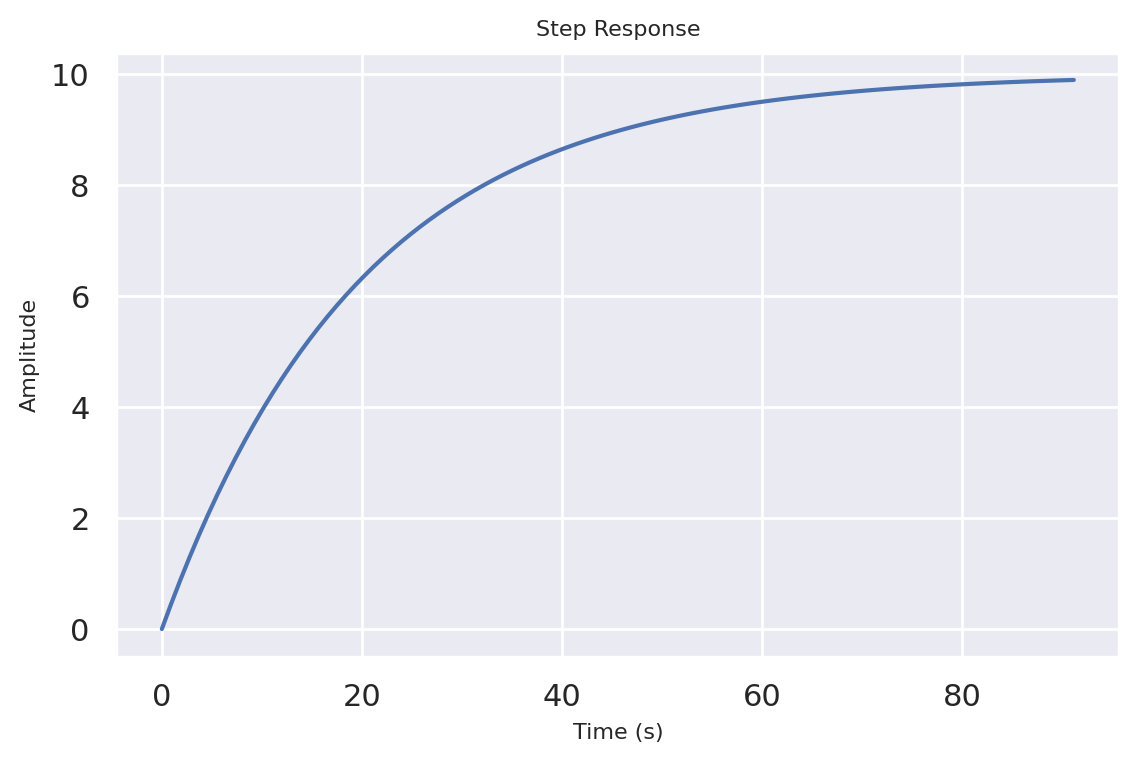

In [3]:
m = 1000
b = 50
u = 500


Kp = 1

P_cruise = 1 / (m * s + b)
C = pid(Kp)

sys = u * C * P_cruise

T, yout = control.step_response(sys=sys)
plt.plot(T, yout)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Step Response")
plt.grid("on")

As you can see, the open-loop system is stable; thus, we can go ahead and generate the Bode plot. Change the above m-file by deleting the |step| command and adding in the following command.

(0.001, 1.0, -62.61381450248391, -31.378166227743304)

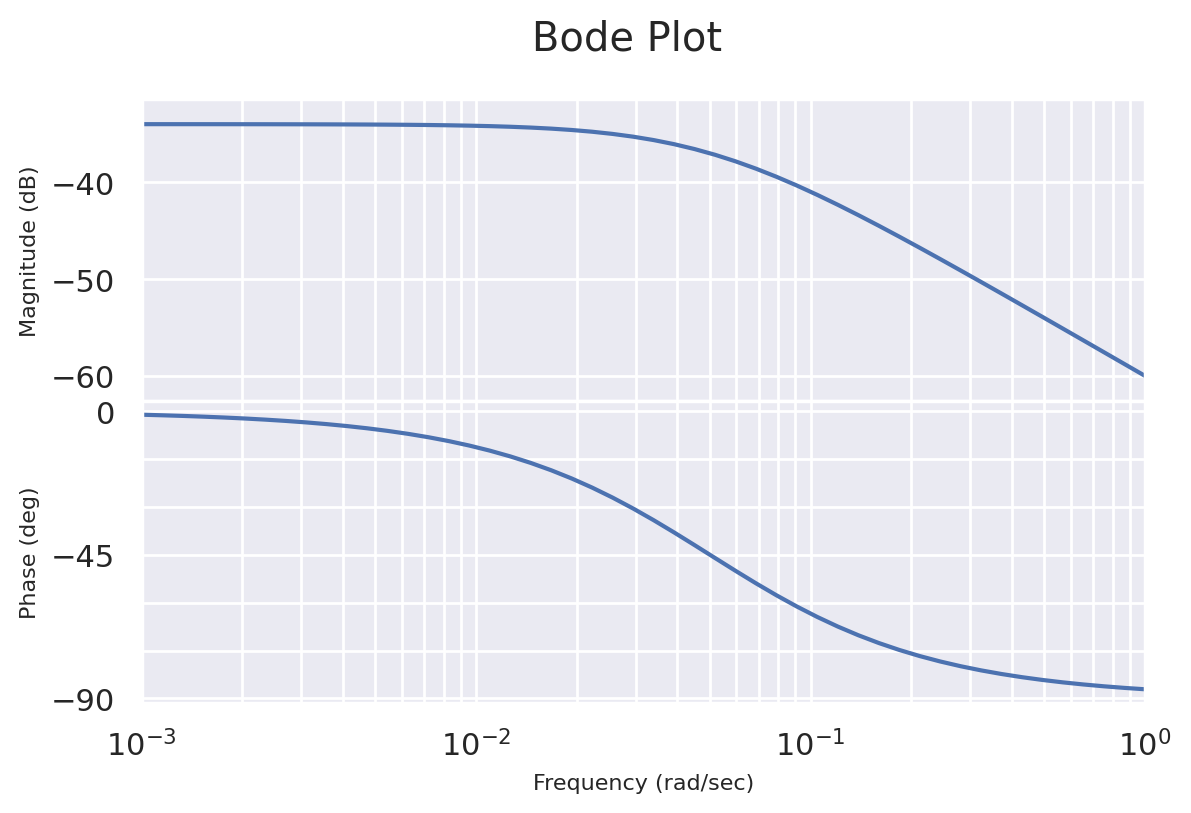

In [4]:
mag, phase, omega = control.bode(C * P_cruise, plot=True, dB=True)
mag_db = 20 * np.log10(mag)
fig = plt.gcf()
fig.suptitle("Bode Plot")
fig.subplots_adjust(hspace=0)
fig.axes[0].label_outer()
# Zoom to data
padding = 0.1
mag_range = np.max(mag_db) - np.min(mag_db)
mag_max = np.max(mag_db) + padding * mag_range
mag_min = np.min(mag_db) - padding * mag_range
fig.axes[0].axis([omega[0], omega[-1], mag_min, mag_max])

## Proportional controller

Refer to the [Introduction: Frequency Domain Methods for Controller Design](../Introduction/Introduction-ControlFrequency.ipynb) page, and let's see what system characteristics we can determine from the above Bode plot. The steady-state error can be found from the following equation: 

$$
 \mathrm{ss \ error} = \frac{1}{1+M_{\omega \rightarrow 0}} \cdot 100\% \ 
$$

For this system, the low frequency gain is -34dB = 0.02; therefore, the steady-state error should be 98%. We can confirm this by generating a closed-loop step response as follows.

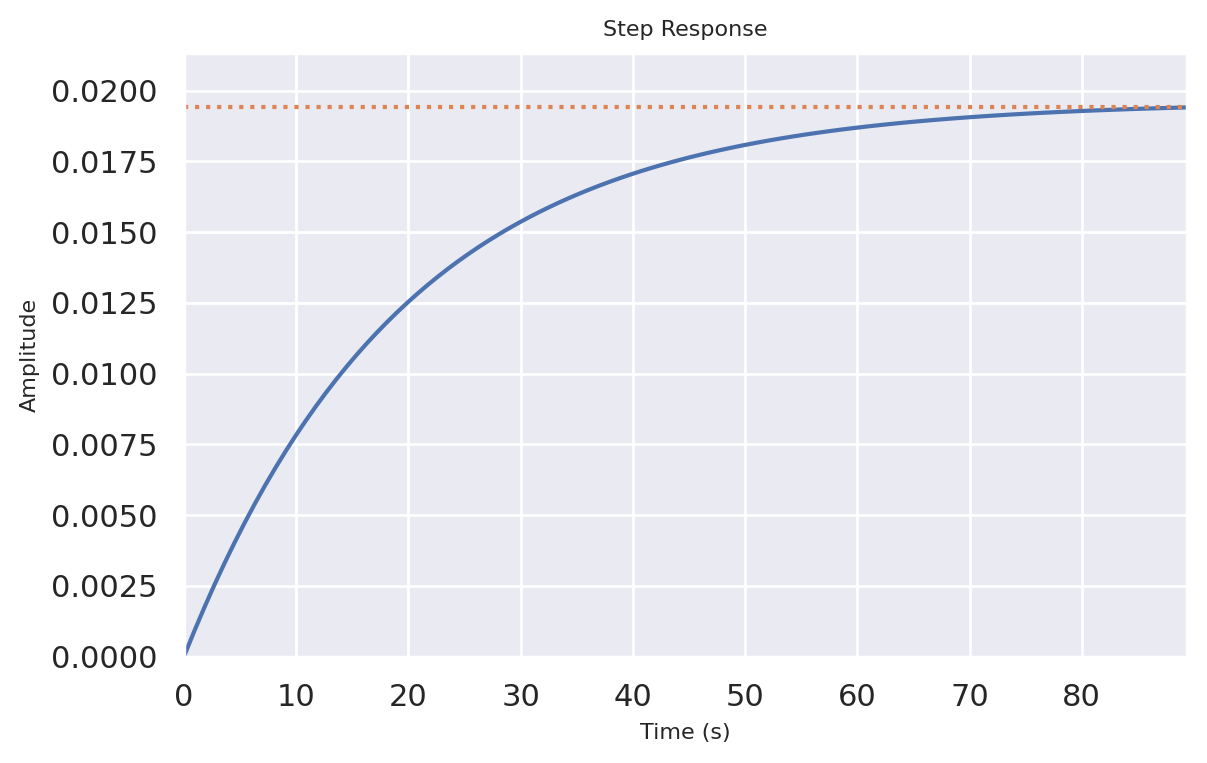

In [5]:
r = 10
sys_cl = control.feedback(C * P_cruise, 1)

T, yout = control.step_response(sys=sys_cl)
step_info = control.step_info(sys=sys_cl)
plt.plot(T, yout)

# Add steady state value as dashed line.
plt.plot(
    [T[0], T[-1]],
    [step_info["SteadyStateValue"], step_info["SteadyStateValue"]],
    linestyle="dotted",
)
ymax = step_info["SteadyStateValue"] * 1.1
plt.axis([T[0], T[-1], 0, ymax])

# Label axes.
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Step Response")
plt.grid("on")

We need to increase the low frequency gain in order to improve the steady-state error. Specifically, the error needs to be < 2%; therefore, 1/(1+ $M_{w=0}$) < 0.02 $\Rightarrow$$M_{w=0}$ > 49 = 33.8 dB. Since, the low frequency gain is -34 dB and the steady-state error limit needs us to have a low frequency gain of 33.8 dB, to reach the desired steady-state error using proportional control only, requires a $K_p$> (34 dB + 33.8 dB) = 67.8 dB = 2455. Let's look at the Bode diagram of the compensated open-loop system.

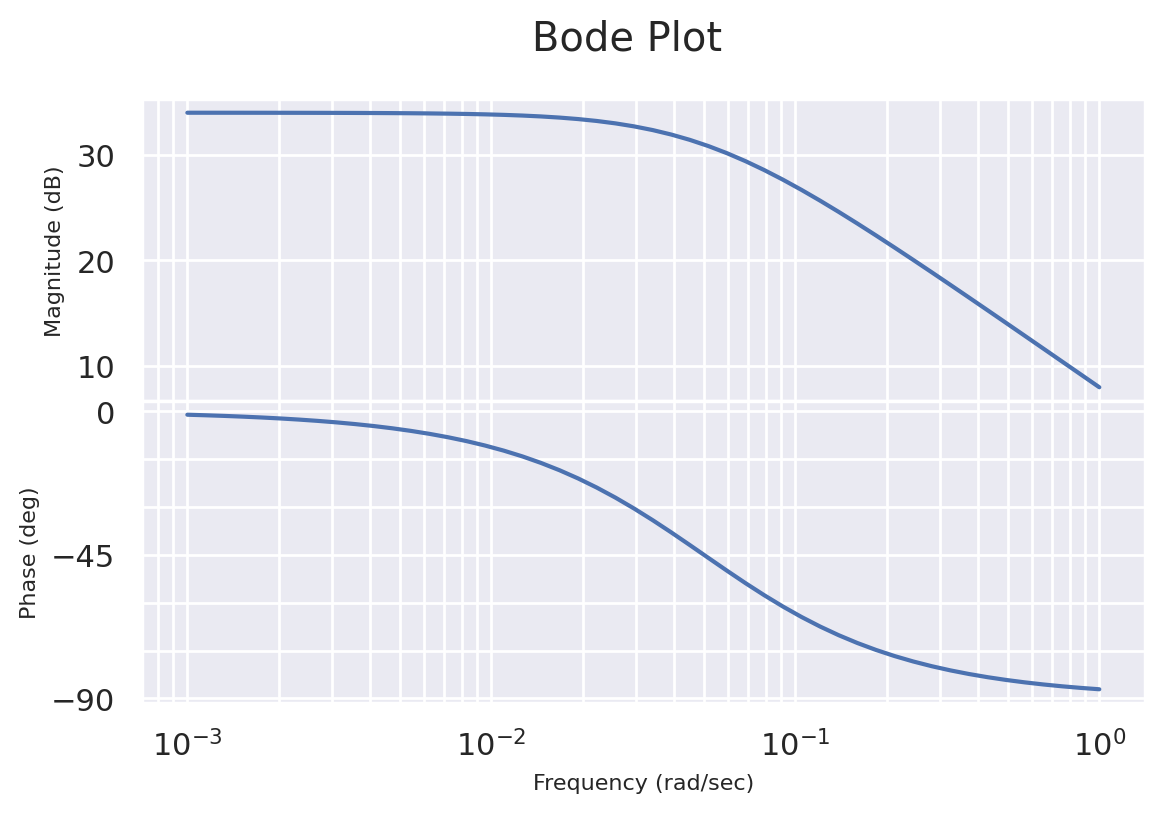

In [6]:
Kp = 2500
C = Kp

control.bode(C * P_cruise, plot=True, dB=True)
fig = plt.gcf()
fig.suptitle("Bode Plot")
fig.subplots_adjust(hspace=0)
fig.axes[0].label_outer()

As you can see from the Bode plot above, the low frequency magnitude is now, 34 dB. Now let's simulate the step response of the closed loop system with this gain.

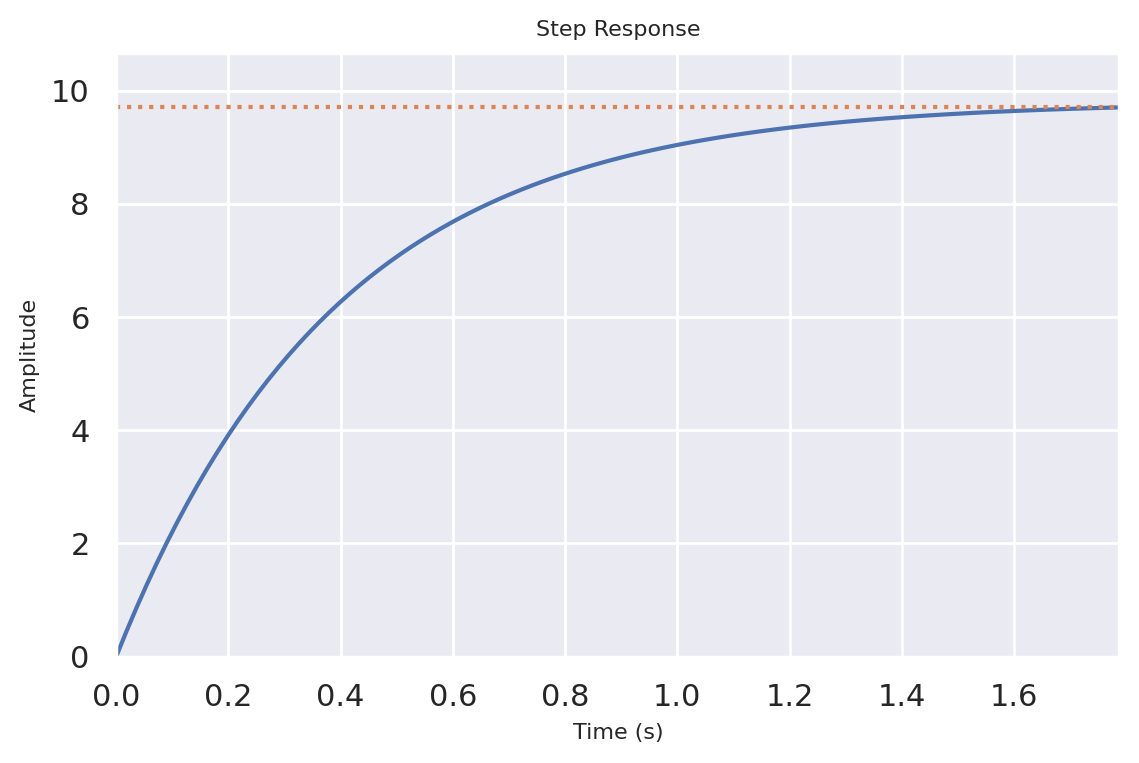

In [7]:
sys_cl = control.feedback(C * P_cruise, 1)
# Plot Step Response
T, yout = control.step_response(sys=r * sys_cl)
step_info = control.step_info(sys=r * sys_cl)
plt.plot(T, yout)

# Add steady state value as dashed line.
plt.plot(
    [T[0], T[-1]],
    [step_info["SteadyStateValue"], step_info["SteadyStateValue"]],
    linestyle="dotted",
)
ymax = step_info["SteadyStateValue"] * 1.1
plt.axis([T[0], T[-1], 0, ymax])

# Label axes.
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Step Response")
plt.grid("on")

The steady-state error meets the requirements; however, the rise time is much shorter than is needed and is unreasonable in this case since the car can not accelerate to 10 m/s in 2 sec. Therefore, we will try using a smaller proportional gain to reduce the control action required along with a lag compensator to reduce the steady-state error. 

## Lag compensator

If you take a look at the "Lag or Phase-Lag Compensator using Frequency Response" section of the Lead and Lag Compensator Design page, the lag compensator adds gain at the low frequencies while keeping the bandwidth frequency at the same place. This is actually what we need: Larger low frequency gain to reduce the steady-state error and keep the same bandwidth frequency to maintain the desired rise time. The transfer function of the lag controller is:

$$
C_{lag}(s) = \frac{s+z_0}{s+p_0} \ 
$$

If you read the "Lag or Phase-Lag Compensator using Root-Locus" section in Lead and Lag Compensator Design page, the pole and the zero of a lag controller need to be placed close together. Also, it states that the steady-state error will be reduced by a factor of $z_0/p_0$. For these reasons, let $z_0$ equal 0.1 and $p_0$ equal 0.02. The proportional gain, $K_p$ = 1000 was chosen by trial-and-error. 

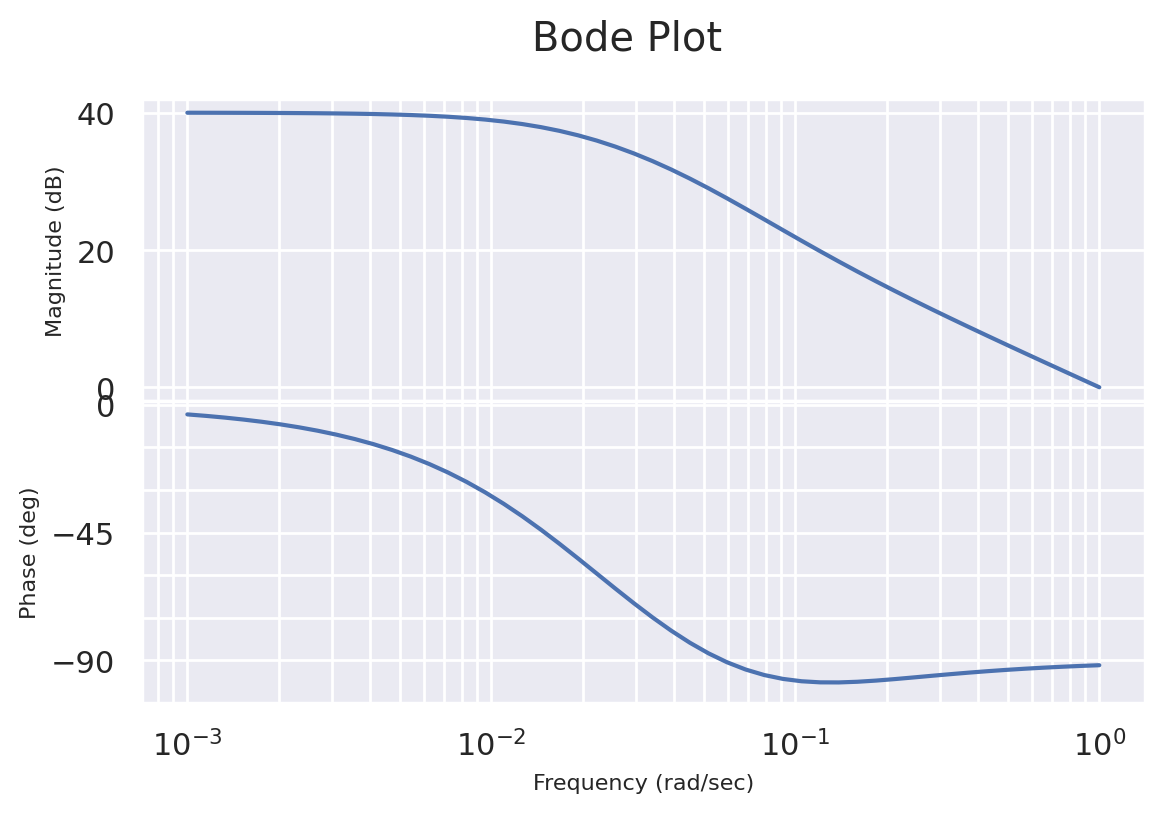

In [8]:
Kp = 1000
zo = 0.1
po = 0.02
C_lag = (s + zo) / (s + po)
#
control.bode(Kp * C_lag * P_cruise, plot=True, dB=True)
fig = plt.gcf()
fig.suptitle("Bode Plot")
fig.subplots_adjust(hspace=0)
fig.axes[0].label_outer()

Let's confirm the performance by generating a closed-loop step response.

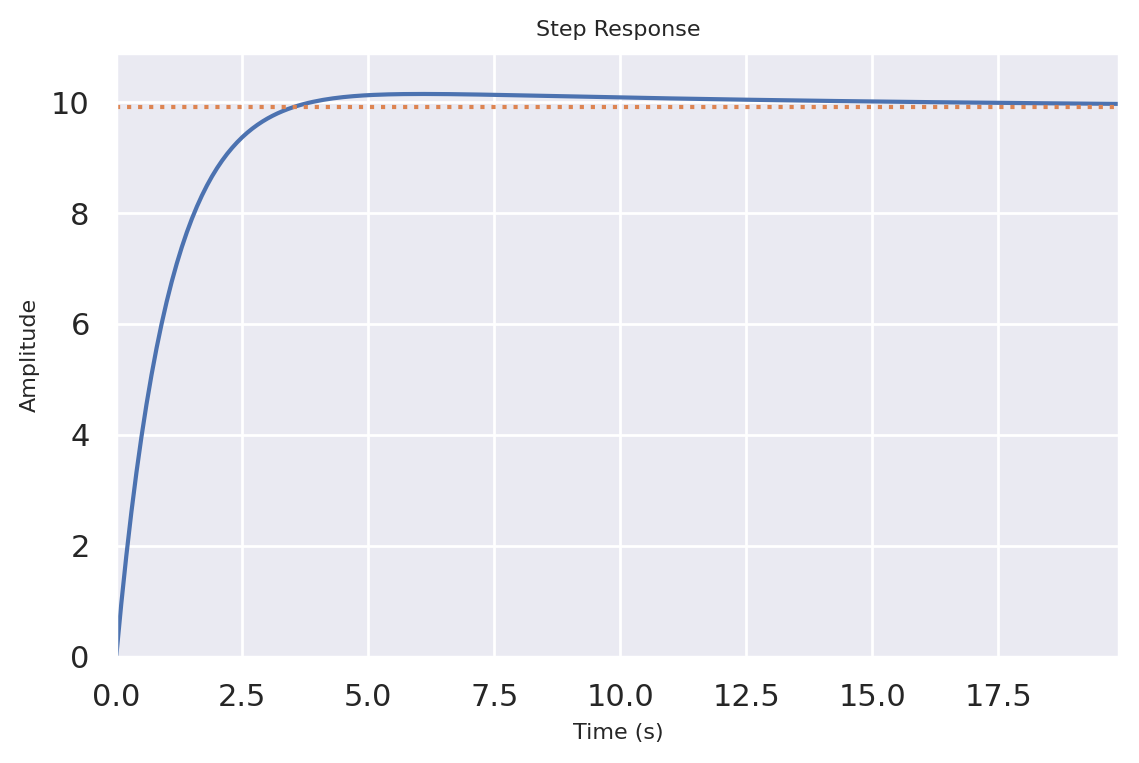

In [9]:
sys_cl = control.feedback(Kp * C_lag * P_cruise, 1)
T, yout = control.step_response(sys=r * sys_cl, T=np.arange(0, 20, 0.1))
step_info = control.step_info(sys=r * sys_cl, T=np.arange(0, 200, 1))
plt.plot(T, yout)

# Add steady state value as dashed line.
plt.plot(
    [T[0], T[-1]],
    [step_info["SteadyStateValue"], step_info["SteadyStateValue"]],
    linestyle="dotted",
)
ymax = step_info["SteadyStateValue"] * 1.1
plt.axis([T[0], T[-1], 0, ymax])

# Label axes.
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Step Response")
plt.grid("on")